#Pre-run stuff
You can just collapse this header and then run all the cells inside to get started

If you get curious about the inner workings of anything, feel free to take a peek

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import torch 

np.random.seed(42)
tf.random.set_seed(42)

##Load Dataset
This is pretty self-explanatory for downloading the dataset. I also create a dictionary here so that I can translate from the label to the name of the class easily in my functions

In [2]:
CIFAR10dict = {0:'airplane', 1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 6s 0us/step


In [4]:
pd.set_option('expand_frame_repr', False) #This just helps with the display later on

##Load Model
solution for loading model found here: https://stackoverflow.com/questions/64097109/load-a-tensorflow-h5-model-hosted-online

This is just how I ended up downloading the model from the gitlab page of our project.

In [5]:
import urllib.request

urllib.request.urlretrieve('https://gitlab.com/CEADS/nuclear_ai_cyber/-/raw/main/fgsm/CIFAR10ModelH5', 'CIFAR10ModelH5')

('CIFAR10ModelH5', <http.client.HTTPMessage at 0x7f241f9e6290>)

In [6]:
MODEL_PATH = './CIFAR10ModelH5'

In [7]:
MODEL = keras.models.load_model(MODEL_PATH)

##Create Functions

###FGSM functions

In [8]:
#This method is the backbone of all of the examples. It is all that you essentially need to do FGSM for image classifications.
def FGSM(model, input, target, eps=.01):
  input = tf.cast(input, tf.float32)
  loss_object = tf.keras.losses.CategoricalCrossentropy()
  with tf.GradientTape() as tape:
    tape.watch(input)
    prediction = model(input)
    loss = -loss_object(target, prediction)
  gradient = tape.gradient(loss, input) #This is probably the most important line of the whole function,
  # as it is what gets the gradients of the inputs and tells us how to generate the noise
  signed_grad = tf.sign(gradient)
  return (signed_grad*eps*255).numpy()

In [9]:
#this function is nessecary because it needs a specific format for the target label
def giveLabel(label, total): 
  labelx = tf.one_hot(label,total)
  return tf.reshape(labelx, (1,total))

In [10]:
#This function just uses the other function, and does it multiple times. instead of pushing each input in one big burst, it
#does it by a fraction of the total amount, and then does it again, thereby honing in better on the target.
def FuncStep(func,model,input,target,eps,steps): 
  temp = input
  for x in range(steps):
    noise = func(model, temp, target, eps/steps)
    temp = np.clip(temp+noise, 0, 255)
  return temp

In [11]:
#this function essentially just does the same as the last one, but it does it for each of the possible classifications.
#It then stores each of the adversaries it creates, and also formats the output in a nice way.
def getTable(stepfunc,func,model,input,labelFunc,eps,steps):
  advlist = []
  df = pd.DataFrame(columns=range(10))
  for x in range(10):
    advlist.append(stepfunc(func, model, input, labelFunc(x,10), eps, steps))
    predictions = (model.predict(advlist[x]).round(3))[0]
    df.loc[x] = predictions.tolist()
  return advlist, df

###Display functions
The display functions are pretty intuitive for the most part. They just do the necessary pre-processing to be able to display the image, and then display it.

In [12]:
def displayNoise(noise):
  plt.title(f"Noise")
  plt.imshow((noise[0]/EPS+255)/2/255)
  plt.show()
  return

In [13]:
def displayPrediction(model, image, index, label):
  image = np.clip(image,0,255)
  prediction = np.argmax(model.predict(image))
  plt.suptitle(f"Adversary towards {label} ({CIFAR10dict[label]})")
  plt.title(f"Prediction: {prediction} ({CIFAR10dict[prediction]}), {round(model.predict(image)[0][prediction]*100,2)}%")
  plt.imshow(np.clip(image[0]/255,0,1))
  plt.show()
  return

In [14]:
def displayOriginal(model, image, index):
  prediction = np.argmax(model.predict(image))
  plt.suptitle(f"Original Image: {y_test[INDEX][0]} ({CIFAR10dict[y_test[INDEX][0]]})")
  plt.title(f"Prediction: {prediction} ({CIFAR10dict[prediction]}), {round(model.predict(image)[0][prediction]*100,2)}%")
  plt.imshow(np.clip(image[0]/255,0,1))
  plt.show()

#Demo Portion
This is where you can run the code to generate your own adversarial images

The comments will tell you which lines of code are recommended to be edited/experimented with, and which ones should be left alone

##FGSM one time
This section is basically just proof-of-concept, and will not have as good of results as the following section

Index 0, Max Epsilon: 0.01, Original Label: 3 (cat), Target Label: 1 (automobile)


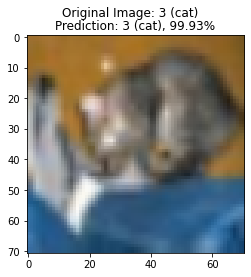

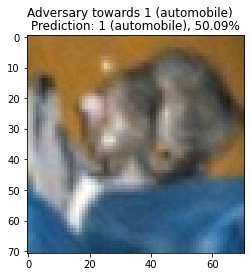

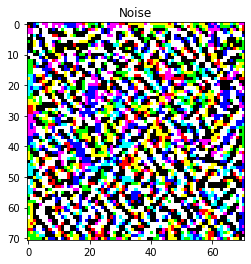

In [15]:
#Feel free to edit these values
INDEX = 0   #any number from 0 to 5000
EPS = .01   #any number from 0 to 1
LABEL = 1   #any integer from 0 to 9, what label you are perturbing the image towards


#don't edit this part
input = tf.image.resize(tf.cast(np.expand_dims(x_test[INDEX],0), tf.float32), (71,71))
noise = FGSM(MODEL,input,giveLabel(LABEL,10),EPS)


#comment out display lines that you don't want to see
print(f"Index {INDEX}, Max Epsilon: {EPS}, Original Label: {y_test[INDEX][0]} ({CIFAR10dict[y_test[INDEX][0]]}), Target Label: {LABEL} ({CIFAR10dict[LABEL]})")
displayOriginal(MODEL, input, INDEX)
displayPrediction(MODEL, input+noise, INDEX, LABEL)
displayNoise(noise)

##FGSM multiple steps
This is the quickest section to experiment with while getting the best results

In [ ]:
#Feel free to edit these values
INDEX = 5000   #any number from 0 to 5000
EPS = .01   #any number from 0 to 1
LABEL = 1   #any integer from 0 to 9, what label you are perturbing the image towards
STEPS = 10  #any integer from 1 to 100 (bigger will take longer)


#don't edit this part
input = tf.image.resize(tf.cast(np.expand_dims(x_test[INDEX],0), tf.float32), (71,71))
adv = FuncStep(FGSM,MODEL,input,giveLabel(LABEL,10),EPS, STEPS)
print("Done! Run the next cell to see results!")

Done! Run the next cell to see results!


Index 5000, Max Epsilon: 0.01, Original Label: 7 (horse), Target Label: 1 (automobile)


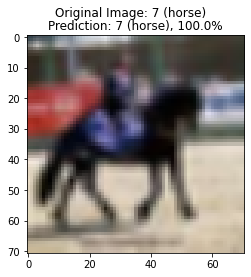

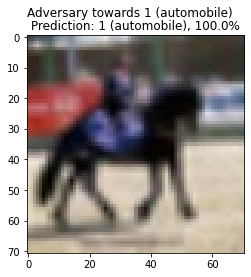

In [ ]:
#comment out display lines that you don't want to see
print(f"Index {INDEX}, Max Epsilon: {EPS}, Original Label: {y_test[INDEX][0]} ({CIFAR10dict[y_test[INDEX][0]]}), Target Label: {LABEL} ({CIFAR10dict[LABEL]})")
displayOriginal(MODEL, input, INDEX)
displayPrediction(MODEL, adv, INDEX, LABEL)

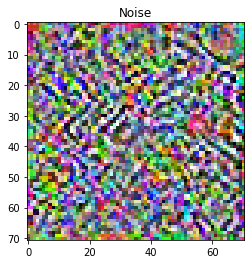

In [ ]:
displayNoise(adv-input)
#print(adv-input)

##FGSM generate all adversaries
This section takes a long time because it generated every adversary for the given index

In [ ]:
#warning, this will take 10x as long as the last one (since it is generating 10 images)
#Feel free to edit these values
INDEX = 14   #any number from 0 to 5000
EPS = .01   #any number from 0 to 1
STEPS = 10  #any integer from 1 to 100 (bigger will take longer)


#don't edit this
input = tf.image.resize(tf.cast(np.expand_dims(x_test[INDEX],0), tf.float32), (71,71))
advlist, table = getTable(FuncStep,FGSM,MODEL,input,giveLabel,EPS,STEPS)
print("Done! Run the next cell to see results!")

Done! Run the next cell to see results!


In [ ]:
#This table generates an adversary for each possible lable, as shown on the left-most column.
print(f"Index {INDEX}, Max Epsilon: {EPS}, Original Label: {y_test[INDEX][0]} ({CIFAR10dict[y_test[INDEX][0]]})")
print(table)

Index 14, Max Epsilon: 0.01, Original Label: 9 (truck)
       0      1      2      3      4      5      6      7      8      9
0  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
1  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
2  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
3  0.001  0.000  0.001  0.998  0.000  0.000  0.000  0.000  0.000  0.000
4  0.002  0.003  0.001  0.005  0.967  0.000  0.000  0.001  0.010  0.010
5  0.011  0.003  0.020  0.071  0.002  0.782  0.003  0.035  0.005  0.067
6  0.001  0.002  0.000  0.005  0.000  0.000  0.988  0.000  0.002  0.002
7  0.021  0.001  0.013  0.026  0.005  0.013  0.001  0.900  0.002  0.018
8  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000
9  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000


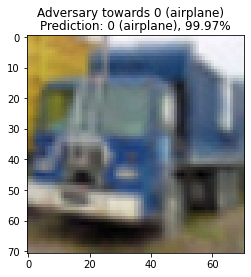

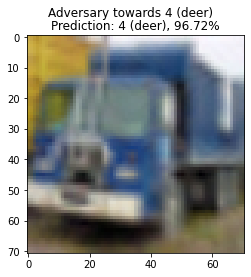

In [ ]:
#For those of you that know some more about python, you can access any of the 10 adversaries using advlist[label]
#Feel free to take a look at and compare them!
TARGET = 0
displayPrediction(MODEL, advlist[TARGET], INDEX, TARGET)
TARGET = 4
displayPrediction(MODEL, advlist[TARGET], INDEX, TARGET)